In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from collections import Counter

In [2]:
TRAIN_PATH = "C:\\Users\\inilo\\OneDrive\\Escritorio\\ClasificadorCNN_Rocas\\src\\data"
TEST_PATH = "C:\\Users\\inilo\\OneDrive\\Escritorio\\ClasificadorCNN_Rocas\\src\\data"
VALID_PATH = "C:\\Users\\inilo\\OneDrive\\Escritorio\\ClasificadorCNN_Rocas\\src\\data"

In [ ]:
train_dir = os.path.join(TRAIN_PATH, 'train')
validation_dir = os.path.join(VALID_PATH, 'valid')
test_dir = os.path.join(TEST_PATH, 'test')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

Found 5667 files belonging to 6 classes.


In [ ]:
# Dataset sin preprocesar para obtener nombres de clases y visualización
test_dataset_raw = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=False,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

In [ ]:
class_names = test_dataset_raw.class_names
print("Clases:", class_names)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def preprocess(image, label):
    image = preprocess_input(image)
    return image, label

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 539 files belonging to 6 classes.


In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=False,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 274 files belonging to 6 classes.


In [ ]:
train_dataset = train_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Extraer X_test e y_test sin preprocesar
X_test_raw = []
y_test = []
for images, labels in test_dataset_raw:
    X_test_raw.extend(images.numpy())
    y_test.extend(labels.numpy())
X_test_raw = np.array(X_test_raw)
y_test = np.array(y_test)

In [10]:
base_model = ResNet50(input_shape=IMG_SIZE + (3,),
                      include_top=False,
                      weights='imagenet')

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # 6 clases
])

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 23850758 (90.98 MB)
Trainable params: 263046 (1.00 MB)
Non-trainable params: 23587712 (89.98 MB)
___________

In [12]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

EPOCHS = 50

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping],
)

Epoch 1/50
175/178 [============================>.] - ETA: 3s - loss: 1.0117 - accuracy: 0.6348

KeyboardInterrupt: 

In [ ]:
# --- FASE 2: Fine-tuning de las últimas capas de ResNet50 ---
base_model.trainable = True

# Descongelar solo las últimas 35 capas
fine_tune_at = 120
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompilar con tasa de aprendizaje baja
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento adicional
total_epochs = EPOCHS + 10

history_finetune = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=[early_stopping]
)

Epoch 26/60


178/178 ━━━━━━━━━━━━━━━━━━━━ 41s 142ms/step - accuracy: 0.7651 - loss: 0.7740 - val_accuracy: 0.8256 - val_loss: 0.6941
Epoch 27/60
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.9433 - loss: 0.1596 - val_accuracy: 0.8386 - val_loss: 0.6633
Epoch 28/60
178/178 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.9746 - loss: 0.0877 - val_accuracy: 0.8460 - val_loss: 0.6482
Epoch 29/60
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9816 - loss: 0.0667 - val_accuracy: 0.8571 - val_loss: 0.6521
Epoch 30/60
178/178 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.9874 - loss: 0.0446 - val_accuracy: 0.8534 - val_loss: 0.6606
Epoch 31/60
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.9896 - loss: 0.0394 - val_accuracy: 0.8590 - val_loss: 0.6598
Epoch 32/60
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.9943 - loss: 0.0265 - val_accuracy: 0.8516 - val_loss: 0.6824
Epoch 33/60
178/178 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.9935 - loss: 0.0250 - val

<Axes: >

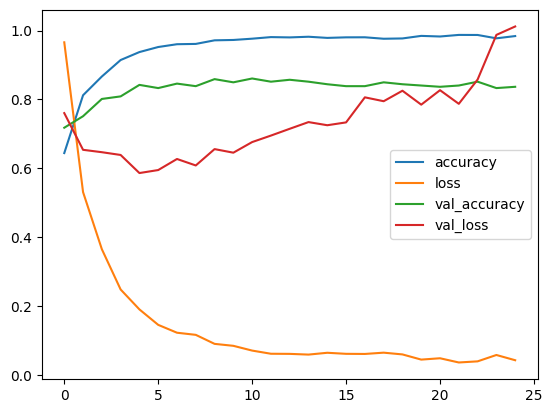

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Precisión en test: {test_accuracy * 100:.2f}%")

8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8683 - loss: 0.6266

I0000 00:00:1747496736.244074  217285 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1698', 244 bytes spill stores, 244 bytes spill loads



9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 422ms/step - accuracy: 0.8706 - loss: 0.6266
Precisión en test: 87.96%


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


2025-05-17 17:45:43.075569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


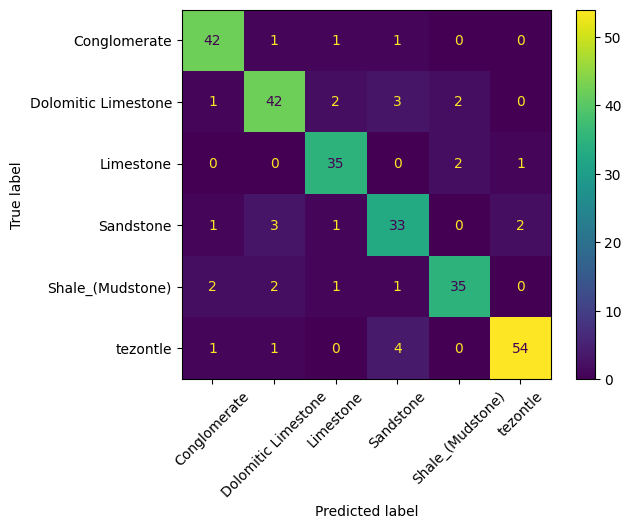

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45)

In [15]:
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

9/9 [==============================] - 6s 659ms/step


In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img.astype("uint8"))

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(len(class_names)))
  plt.yticks([])
  thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..133.1546].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..142.32639].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.491234..131.32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..131.32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..148.44876].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..118.70385].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..143.65805].
Clipping 

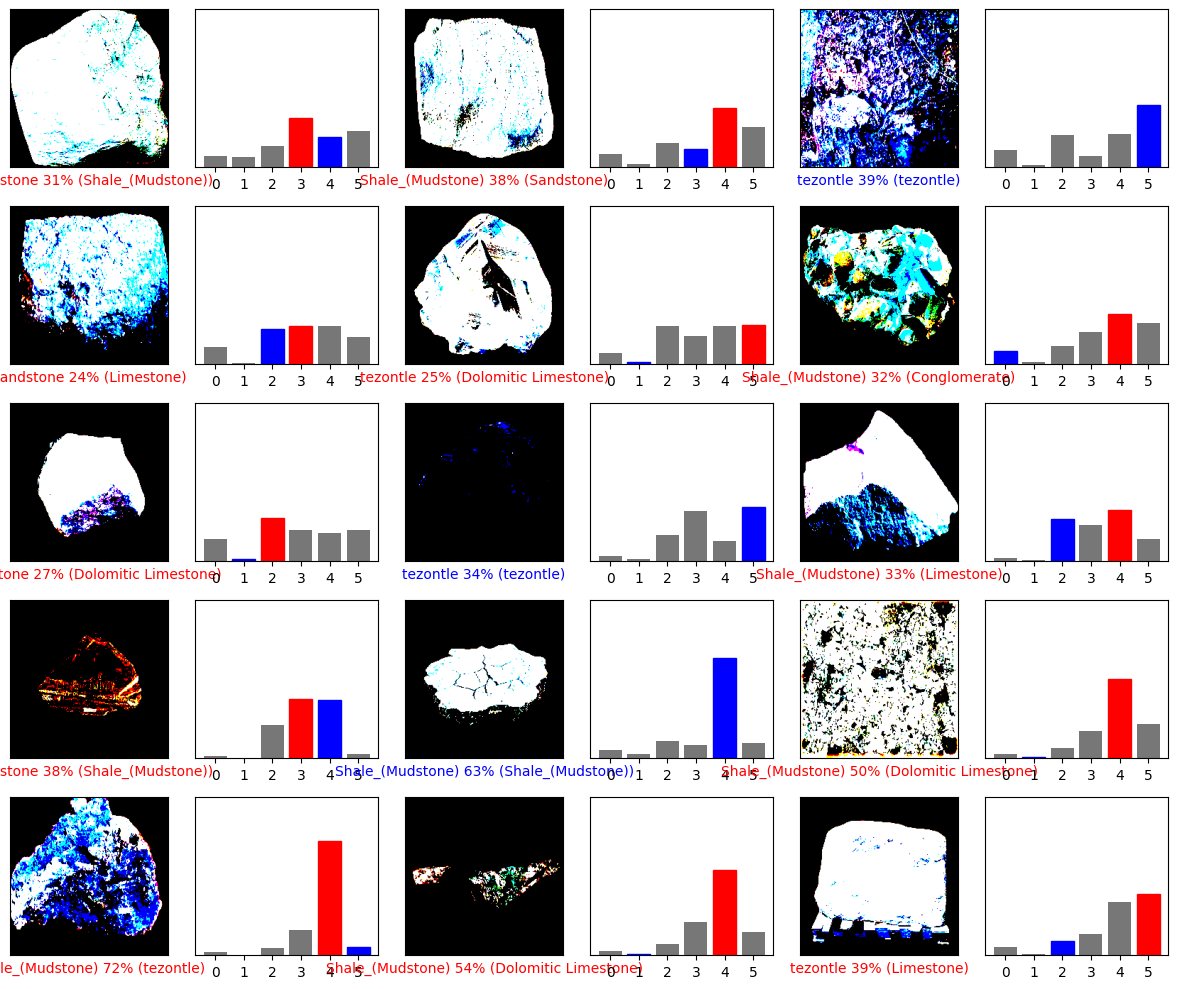

In [ ]:
random_indices = np.random.choice(len(X_test_raw), num_images, replace=False)
plt.figure(figsize=(18, 15))
for i, idx in enumerate(random_indices):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(idx, y_pred_probs[idx], y_test, X_test_raw)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(idx, y_pred_probs[idx], y_test)
plt.tight_layout()
plt.show()

In [ ]:
confidences = np.max(y_pred_probs, axis=1)

# Histograma de confianzas
plt.hist(confidences, bins=20)
plt.xlabel('Confianza de predicción')
plt.ylabel('Número de imágenes')
plt.title('Distribución de confianzas del modelo')
plt.show()

In [ ]:
wrong_confident = [(i, conf) for i, (conf, true, pred) in enumerate(zip(confidences, y_test, y_pred)) if true != pred and conf > 0.9]

print(f"Número de errores con confianza > 90%: {len(wrong_confident)}")